In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import shutil
import gdown
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

#Pengumpulan Dataset

In [ ]:
# --- PENGATURAN ---
drive_file_id = "1kXZ-ikeTLDEHxiM8c9U7sn1UFz1JJ3xa"
final_extraction_target_folder = '/content/dataset'
temp_zip_filename = '/content/temp_gdown_dataset.zip'
# --- SELESAI PENGATURAN ---

def get_common_prefix(paths):
    """Mencari prefix direktori umum terpanjang dari daftar path."""
    if not paths:
        return None
    prefix = os.path.commonprefix(paths)
    if prefix and not prefix.endswith('/'):
        last_slash = prefix.rfind('/')
        if last_slash != -1:
            prefix = prefix[:last_slash+1]
        else: # Tidak ada '/' dalam prefix, berarti tidak ada common directory
            return None
    if prefix: # Verifikasi apakah semua path benar-benar dimulai dengan prefix ini
        all_match = True
        for p in paths:
            if not p.startswith(prefix):
                all_match = False
                break
        if not all_match:
            return None
    else: # Jika prefix kosong
        return None
    return prefix

def download_and_extract_with_gdown(file_id, final_target_folder, output_zip_path):
    """
    Mengunduh file dari Google Drive menggunakan gdown dan mengekstrak isinya.
    Jika ada satu folder root di dalam zip, isinya yang akan diekstrak.
    Folder target akan dibersihkan terlebih dahulu.
    """
    # 1. Bersihkan folder target jika sudah ada
    if os.path.exists(final_target_folder):
        print(f"Membersihkan folder target yang sudah ada: {final_target_folder}")
        try:
            shutil.rmtree(final_target_folder)
        except Exception as e:
            print(f"Error saat membersihkan folder target '{final_target_folder}': {e}")
            # return False # Anda bisa memilih untuk berhenti jika pembersihan gagal
    try:
        os.makedirs(final_target_folder, exist_ok=True)
        print(f"Folder target '{final_target_folder}' siap.")
    except Exception as e:
        print(f"Error membuat folder target '{final_target_folder}': {e}")
        return False

    # 2. Unduh file ZIP menggunakan gdown
    try:
        print(f"Mengunduh dataset menggunakan gdown (ID: {file_id}) ke {output_zip_path}...")
        gdown.download(id=file_id, output=output_zip_path, quiet=False)
        print(f"Dataset berhasil diunduh sebagai {output_zip_path}")

        # Opsional: Cek ukuran file setelah diunduh
        if os.path.exists(output_zip_path):
            file_size = os.path.getsize(output_zip_path)
            print(f"Ukuran file yang diunduh ({output_zip_path}): {file_size} bytes")
            if file_size < 10000: # Ukuran di bawah 10KB mungkin masih mencurigakan untuk dataset
                print("PERINGATAN: Ukuran file yang diunduh dengan gdown masih sangat kecil.")
        else:
            print(f"Error: File {output_zip_path} tidak ditemukan setelah proses unduh gdown.")
            return False

    except Exception as e:
        print(f"Error saat mengunduh dengan gdown: {e}")
        return False

    # 3. Ekstrak file ZIP
    try:
        print(f"Mengekstrak '{output_zip_path}'...")
        with zipfile.ZipFile(output_zip_path, 'r') as zip_ref:
            namelist = zip_ref.namelist()
            if not namelist:
                print("Error: File ZIP kosong.")
                return False # Hapus zip sementara di finally block

            common_prefix = get_common_prefix(namelist)

            if common_prefix:
                print(f"Folder root terdeteksi di dalam ZIP: '{common_prefix}'. Isinya akan diekstrak langsung.")
                for member_info in zip_ref.infolist():
                    if member_info.filename.startswith(common_prefix):
                        target_filename = member_info.filename[len(common_prefix):]
                    else:
                        target_filename = member_info.filename
                    if not target_filename: # Skip entri kosong (jika common_prefix adalah satu-satunya isi)
                        continue
                    target_path = os.path.join(final_target_folder, target_filename)
                    if member_info.is_dir():
                        os.makedirs(target_path, exist_ok=True)
                    else:
                        # Pastikan direktori untuk file ini ada sebelum menulis file
                        os.makedirs(os.path.dirname(target_path), exist_ok=True)
                        with open(target_path, 'wb') as outfile:
                            outfile.write(zip_ref.read(member_info.filename))
                print(f"Isi dari '{common_prefix}' telah diekstrak ke '{final_target_folder}'.")
            else:
                print("Tidak ada folder root tunggal terdeteksi di ZIP, atau file berada di root. Mengekstrak semua...")
                zip_ref.extractall(final_target_folder)
                print(f"Semua isi ZIP telah diekstrak ke '{final_target_folder}'.")
        return True
    except zipfile.BadZipFile:
        print(f"Error: File yang diunduh dengan gdown bukan file zip yang valid atau rusak.")
        return False
    except Exception as e:
        print(f"Terjadi error saat ekstraksi: {e}")
        return False
    finally:
        # 4. Hapus file ZIP sementara
        if os.path.exists(output_zip_path):
            print(f"Menghapus file ZIP sementara: {output_zip_path}")
            os.remove(output_zip_path)

# --- Panggil fungsi ---
success = download_and_extract_with_gdown(drive_file_id, final_extraction_target_folder, temp_zip_filename)

if success:
    print(f"\nProses selesai. Dataset seharusnya tersedia di: {final_extraction_target_folder}")
    if os.path.exists(final_extraction_target_folder) and os.listdir(final_extraction_target_folder):
        print(f"\nBeberapa isi dari '{final_extraction_target_folder}':")
        for i, item in enumerate(os.listdir(final_extraction_target_folder)):
            if i < 10: print(f"- {item}")
            else:
                print(f"... dan {len(os.listdir(final_extraction_target_folder)) - 10} item lainnya.")
                break
    else: print(f"Folder '{final_extraction_target_folder}' kosong atau tidak ditemukan.")
else:
    print("\nProses unduh dan ekstraksi gagal.")

Folder target '/content/dataset' siap.
Mengunduh dataset menggunakan gdown (ID: 1kXZ-ikeTLDEHxiM8c9U7sn1UFz1JJ3xa) ke /content/temp_gdown_dataset.zip...


Downloading...
From (original): https://drive.google.com/uc?id=1kXZ-ikeTLDEHxiM8c9U7sn1UFz1JJ3xa
From (redirected): https://drive.google.com/uc?id=1kXZ-ikeTLDEHxiM8c9U7sn1UFz1JJ3xa&confirm=t&uuid=f4dcf8ae-e79c-4fda-89a2-844130967d6d
To: /content/temp_gdown_dataset.zip
100%|██████████| 1.17G/1.17G [00:19<00:00, 59.3MB/s]


Dataset berhasil diunduh sebagai /content/temp_gdown_dataset.zip
Ukuran file yang diunduh (/content/temp_gdown_dataset.zip): 1171031127 bytes
Mengekstrak '/content/temp_gdown_dataset.zip'...
Folder root terdeteksi di dalam ZIP: 'Ecowaste-Dataset/'. Isinya akan diekstrak langsung.
Isi dari 'Ecowaste-Dataset/' telah diekstrak ke '/content/dataset'.
Menghapus file ZIP sementara: /content/temp_gdown_dataset.zip

Proses selesai. Dataset seharusnya tersedia di: /content/dataset

Beberapa isi dari '/content/dataset':
- Plastik
- Organik
- Kertas


Membaca kelas dari: /content/dataset
- Ditemukan kelas: Plastik, Jumlah gambar: 3457
- Ditemukan kelas: Organik, Jumlah gambar: 6750
- Ditemukan kelas: Kertas, Jumlah gambar: 5466


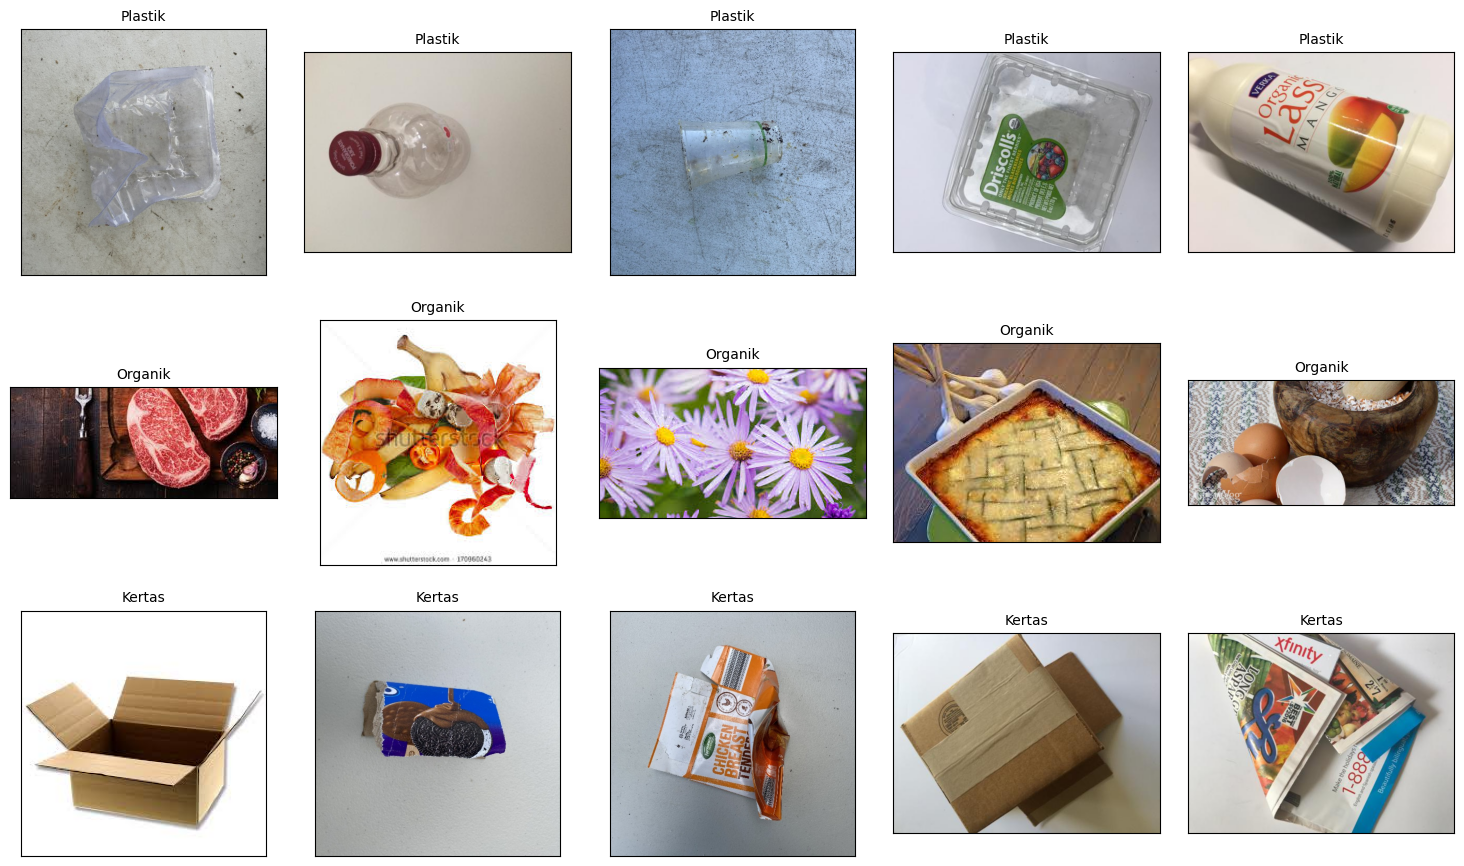

In [ ]:
path_data_kelas = "/content/dataset"

# Membuat kamus yang menyimpan daftar nama file gambar untuk setiap kelas
nama_file_per_kelas = {}
daftar_kelas = []

# Pastikan path_data_kelas ada
if not os.path.exists(path_data_kelas):
    print(f"Error: Path '{path_data_kelas}' tidak ditemukan. Pastikan sudah benar.")
else:
    print(f"Membaca kelas dari: {path_data_kelas}")
    for nama_kelas in os.listdir(path_data_kelas):
        folder_kelas_path = os.path.join(path_data_kelas, nama_kelas)
        # Pastikan itu adalah direktori dan bukan file tersembunyi seperti .ipynb_checkpoints
        if os.path.isdir(folder_kelas_path) and not nama_kelas.startswith('.'):
            nama_file_per_kelas[nama_kelas] = [f for f in os.listdir(folder_kelas_path) if os.path.isfile(os.path.join(folder_kelas_path, f))]
            daftar_kelas.append(nama_kelas)
            print(f"- Ditemukan kelas: {nama_kelas}, Jumlah gambar: {len(nama_file_per_kelas[nama_kelas])}")

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data
if nama_file_per_kelas:
    # Tentukan jumlah baris berdasarkan jumlah kelas yang ditemukan
    num_rows = len(daftar_kelas)
    fig, axs = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows))

    if num_rows == 1:
        axs = np.array([axs]) # Ubah menjadi array 2D dengan satu baris

    for i, nama_kelas_plot in enumerate(daftar_kelas):
        jumlah_gambar_di_kelas = len(nama_file_per_kelas[nama_kelas_plot])
        if jumlah_gambar_di_kelas == 0:
            print(f"Tidak ada gambar di kelas '{nama_kelas_plot}', baris ini akan kosong.")
            for j_col in range(5):
                 axs[i, j_col].axis('off')
            continue

        # Pilih 5 gambar secara acak, jika kurang dari 5, pilih semua yang ada dengan duplikasi (replace=True)
        sampel_gambar = np.random.choice(
            nama_file_per_kelas[nama_kelas_plot],
            size=min(5, jumlah_gambar_di_kelas), # Pilih 5 atau jumlah yang ada jika kurang
            replace=False # Jangan pilih gambar yang sama dua kali
        )

        for j, nama_gambar in enumerate(sampel_gambar):
            path_gambar = os.path.join(path_data_kelas, nama_kelas_plot, nama_gambar)
            try:
                img = Image.open(path_gambar)
                axs[i, j].imshow(img)
                axs[i, j].set_title(nama_kelas_plot, fontsize=10) # Judul di atas gambar
                axs[i, j].set_xticks([]) # Hilangkan tanda sumbu x
                axs[i, j].set_yticks([]) # Hilangkan tanda sumbu y
            except FileNotFoundError:
                print(f"Gambar tidak ditemukan: {path_gambar}")
                axs[i, j].text(0.5, 0.5, 'Gambar\nTidak Ditemukan', horizontalalignment='center', verticalalignment='center')
                axs[i, j].axis('off')
            except Exception as e:
                print(f"Error membuka gambar {path_gambar}: {e}")
                axs[i, j].text(0.5, 0.5, 'Error\nMembuka Gambar', horizontalalignment='center', verticalalignment='center')
                axs[i, j].axis('off')

        # Jika gambar yang dipilih kurang dari 5, matikan subplot yang tersisa di baris itu
        for j_sisa in range(len(sampel_gambar), 5):
            axs[i, j_sisa].axis('off')


    fig.tight_layout(pad=2.0) # Menambahkan padding agar judul tidak tumpang tindih
    plt.show()
else:
    print("Tidak ada kelas atau gambar yang ditemukan untuk ditampilkan. Periksa kembali 'path_data_kelas'.")

Memproses data dari: /content/dataset
  Memproses kelas: Plastik
  Memproses kelas: Organik
    Melewati file non-gambar: grass-clippings.jpg.webp
    Melewati file non-gambar: accectable-bags.webp
    Melewati file non-gambar: FI-58.jpg.webp
    Melewati file non-gambar: crushing-eggshells.jpg.webp
    Melewati file non-gambar: Kraft-Paper-Lawn-and-Leaf-Bag-Collect-Leaves-and-Yard-Waste.webp
  Memproses kelas: Kertas

Contoh beberapa data dari DataFrame:
                                          path           file_name   labels
0     /content/dataset/Plastik/plastic_502.jpg     plastic_502.jpg  Plastik
1    /content/dataset/Plastik/plastic_1630.jpg    plastic_1630.jpg  Plastik
2     /content/dataset/Plastik/Plastic_170.jpg     Plastic_170.jpg  Plastik
3  /content/dataset/Plastik/plastic_396(1).jpg  plastic_396(1).jpg  Plastik
4    /content/dataset/Plastik/plastic_1118.jpg    plastic_1118.jpg  Plastik

Total gambar yang diproses: 15668
Distribusi kelas:
labels
Organik    6745
Kertas  

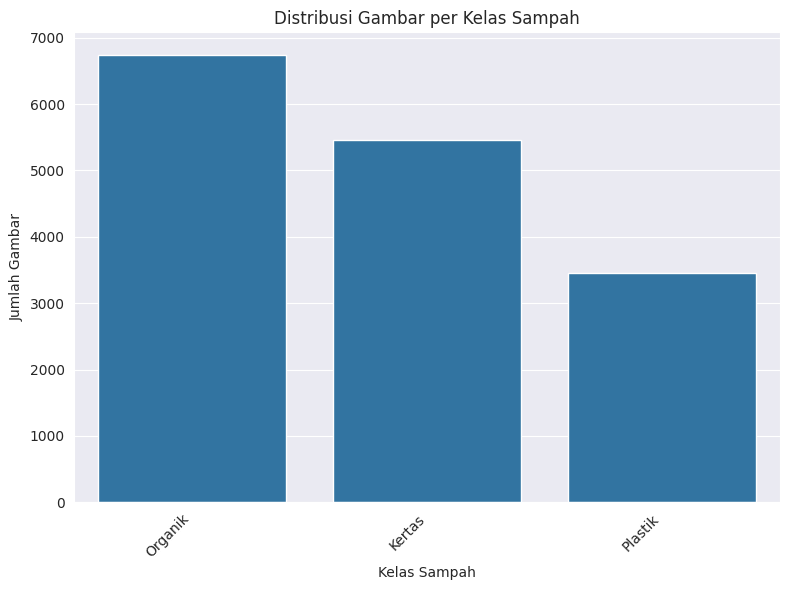

In [ ]:

path_data_utama = "/content/dataset"
# --- Selesai Penyesuaian Path ---

# Buat daftar untuk menyimpan data
file_name_list = []
labels_list = []
full_path_list = []

# Pastikan path utama ada
if not os.path.exists(path_data_utama):
    print(f"Error: Path '{path_data_utama}' tidak ditemukan. Pastikan sudah benar.")
else:
    print(f"Memproses data dari: {path_data_utama}")

    for root, subdirs, files in os.walk(path_data_utama):

        if root != path_data_utama and files:
            nama_kelas = os.path.basename(root) # Ini akan menjadi 'Organik', 'Kertas', dll.
            print(f"  Memproses kelas: {nama_kelas}")
            for name in files:
                # Pastikan hanya memproses file gambar yang umum (opsional, tapi baik untuk kebersihan data)
                if name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    full_path_list.append(os.path.join(root, name))
                    labels_list.append(nama_kelas)
                    file_name_list.append(name)
                else:
                    print(f"    Melewati file non-gambar: {name}")

    # Buat DataFrame dari daftar yang sudah dikumpulkan
    if full_path_list: # Hanya buat DataFrame jika ada data yang terkumpul
        df_distribusi = pd.DataFrame({
            "path": full_path_list,
            'file_name': file_name_list,
            "labels": labels_list
        })

        print("\nContoh beberapa data dari DataFrame:")
        print(df_distribusi.head())

        print(f"\nTotal gambar yang diproses: {len(df_distribusi)}")
        print("Distribusi kelas:")
        print(df_distribusi['labels'].value_counts())

        # Plot distribusi gambar di setiap kelas
        plt.figure(figsize=(8, 6)) # Ukuran plot bisa disesuaikan
        sns.set_style("darkgrid")
        plot = sns.countplot(x='labels', data=df_distribusi, order=df_distribusi['labels'].value_counts().index)
        plot.set_title('Distribusi Gambar per Kelas Sampah')
        plot.set_xlabel('Kelas Sampah')
        plot.set_ylabel('Jumlah Gambar')
        plt.xticks(rotation=45, ha='right') # Rotasi label sumbu x agar mudah dibaca jika nama kelas panjang
        plt.tight_layout() # Agar tidak ada yang terpotong
        plt.show()
    else:
        print("Tidak ada file gambar yang ditemukan untuk membuat DataFrame dan plot.")

#Augmentasi Data

In [ ]:
# --- Pengaturan Dasar ---
path_data_utama = "/content/dataset" # Path ke folder dataset utama Anda

# --- 1. Dapatkan Jumlah Gambar per Kelas dan Tentukan Target ---
jumlah_gambar_per_kelas = {}
daftar_kelas_valid = []

if os.path.exists(path_data_utama):
    for nama_kelas in os.listdir(path_data_utama):
        path_folder_kelas = os.path.join(path_data_utama, nama_kelas)
        if os.path.isdir(path_folder_kelas) and not nama_kelas.startswith('.'):
            # Hitung hanya file gambar yang valid
            file_list = [f for f in os.listdir(path_folder_kelas)
                         if os.path.isfile(os.path.join(path_folder_kelas, f)) and
                         f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            jumlah_gambar_per_kelas[nama_kelas] = len(file_list)
            daftar_kelas_valid.append(nama_kelas)
else:
    print(f"Error: Path dataset utama '{path_data_utama}' tidak ditemukan.")
    exit() # Keluar jika path dasar tidak ada

if not jumlah_gambar_per_kelas:
    print("Tidak ada kelas yang ditemukan dalam dataset.")
    exit()

print("Jumlah gambar awal per kelas:")
for kelas, jumlah in jumlah_gambar_per_kelas.items():
    print(f"- {kelas}: {jumlah}")

# Tentukan target jumlah gambar per kelas (berdasarkan kelas mayoritas)
if jumlah_gambar_per_kelas:
    target_jumlah_gambar_per_kelas = max(jumlah_gambar_per_kelas.values())
else:
    target_jumlah_gambar_per_kelas = 0 # Default jika tidak ada kelas

print(f"\nTarget jumlah gambar per kelas (berdasarkan kelas mayoritas): {target_jumlah_gambar_per_kelas}")







Jumlah gambar awal per kelas:
- Plastik: 3457
- Organik: 6742
- Kertas: 5466

Target jumlah gambar per kelas (berdasarkan kelas mayoritas): 6742


In [ ]:
# --- 2. Konfigurasi ImageDataGenerator untuk Augmentasi ---
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)

In [ ]:
# --- 3. Proses Augmentasi untuk Setiap Kelas yang Membutuhkan ---
for nama_kelas_proses in daftar_kelas_valid:
    path_kelas_sumber = os.path.join(path_data_utama, nama_kelas_proses)
    jumlah_gambar_asli_saat_ini = jumlah_gambar_per_kelas[nama_kelas_proses]

    print(f"\nMemproses kelas: {nama_kelas_proses} (Jumlah asli: {jumlah_gambar_asli_saat_ini})")

    if jumlah_gambar_asli_saat_ini >= target_jumlah_gambar_per_kelas:
        print(f"Kelas '{nama_kelas_proses}' sudah mencapai atau melebihi target. Tidak ada augmentasi.")
        continue # Lanjut ke kelas berikutnya

    if jumlah_gambar_asli_saat_ini == 0:
        print(f"Kelas '{nama_kelas_proses}' tidak memiliki gambar asli. Tidak bisa melakukan augmentasi.")
        continue

    jumlah_gambar_perlu_dihasilkan = target_jumlah_gambar_per_kelas - jumlah_gambar_asli_saat_ini
    # Rata-rata gambar augmentasi yang akan dihasilkan per gambar asli
    gambar_dihasilkan_per_asli = int(np.ceil(jumlah_gambar_perlu_dihasilkan / jumlah_gambar_asli_saat_ini))
    gambar_dihasilkan_per_asli = max(1, gambar_dihasilkan_per_asli) # Pastikan minimal 1

    print(f"  Perlu menghasilkan: {jumlah_gambar_perlu_dihasilkan} gambar augmentasi.")
    print(f"  Akan menghasilkan ~{gambar_dihasilkan_per_asli} gambar augmentasi per gambar asli.")

    total_gambar_tersimpan_untuk_kelas_ini = 0
    # Dapatkan daftar file gambar asli dari folder sumber
    file_list_sumber = [f for f in os.listdir(path_kelas_sumber)
                        if os.path.isfile(os.path.join(path_kelas_sumber, f)) and
                        f.lower().endswith(('.png', '.jpg', '.jpeg')) and
                        not f.startswith('aug_')] # Hindari mengaugmentasi gambar yang sudah diaugmentasi

    if not file_list_sumber:
        print(f"  Tidak ada gambar asli (non-augmented) ditemukan di kelas '{nama_kelas_proses}' untuk diaugmentasi.")
        continue

    for nama_file in file_list_sumber:
        path_gambar_asli = os.path.join(path_kelas_sumber, nama_file)
        try:
            img = load_img(path_gambar_asli)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            i = 0
            # Simpan langsung ke folder kelas aslinya
            save_to_directory = path_kelas_sumber
            prefix_nama = f"aug_{os.path.splitext(nama_file)[0]}" # Prefix untuk nama file augmented

            for batch in datagen.flow(x, batch_size=1,
                                      save_to_dir=save_to_directory,
                                      save_prefix=prefix_nama,
                                      save_format='jpg'):
                i += 1
                total_gambar_tersimpan_untuk_kelas_ini += 1
                if i >= gambar_dihasilkan_per_asli or total_gambar_tersimpan_untuk_kelas_ini >= jumlah_gambar_perlu_dihasilkan:
                    break
        except Exception as e:
            print(f"  Error saat memproses {nama_file}: {e}. Dilewati.")

        if total_gambar_tersimpan_untuk_kelas_ini >= jumlah_gambar_perlu_dihasilkan:
            print(f"  Target {jumlah_gambar_perlu_dihasilkan} gambar augmentasi untuk kelas '{nama_kelas_proses}' telah tercapai.")
            break

    print(f"  Selesai untuk kelas '{nama_kelas_proses}'. Total {total_gambar_tersimpan_untuk_kelas_ini} gambar baru ditambahkan.")

print("\n--- Proses Augmentasi Selesai ---")


Memproses kelas: Plastik (Jumlah asli: 3457)
  Perlu menghasilkan: 3285 gambar augmentasi.
  Akan menghasilkan ~1 gambar augmentasi per gambar asli.
  Target 3285 gambar augmentasi untuk kelas 'Plastik' telah tercapai.
  Selesai untuk kelas 'Plastik'. Total 3285 gambar baru ditambahkan.

Memproses kelas: Organik (Jumlah asli: 6742)
Kelas 'Organik' sudah mencapai atau melebihi target. Tidak ada augmentasi.

Memproses kelas: Kertas (Jumlah asli: 5466)
  Perlu menghasilkan: 1276 gambar augmentasi.
  Akan menghasilkan ~1 gambar augmentasi per gambar asli.
  Target 1276 gambar augmentasi untuk kelas 'Kertas' telah tercapai.
  Selesai untuk kelas 'Kertas'. Total 1276 gambar baru ditambahkan.

--- Proses Augmentasi Selesai ---


In [ ]:
# --- 4. Verifikasi Jumlah Gambar Setelah Augmentasi ---
print("\nJumlah gambar setelah augmentasi per kelas:")
for nama_kelas_cek in daftar_kelas_valid:
    path_folder_kelas_cek = os.path.join(path_data_utama, nama_kelas_cek)
    file_list_cek = [f for f in os.listdir(path_folder_kelas_cek)
                     if os.path.isfile(os.path.join(path_folder_kelas_cek, f)) and
                     f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"- {nama_kelas_cek}: {len(file_list_cek)}")


Jumlah gambar setelah augmentasi per kelas:
- Plastik: 6742
- Organik: 6742
- Kertas: 6742


Memproses data dari: /content/dataset
  Memproses kelas: Plastik
  Memproses kelas: Organik
    Melewati file non-gambar: grass-clippings.jpg.webp
    Melewati file non-gambar: accectable-bags.webp
    Melewati file non-gambar: FI-58.jpg.webp
    Melewati file non-gambar: crushing-eggshells.jpg.webp
    Melewati file non-gambar: Kraft-Paper-Lawn-and-Leaf-Bag-Collect-Leaves-and-Yard-Waste.webp
  Memproses kelas: Kertas

Contoh beberapa data dari DataFrame:
                                                path  \
0           /content/dataset/Plastik/plastic_502.jpg   
1  /content/dataset/Plastik/aug_Plastic_285_0_883...   
2          /content/dataset/Plastik/plastic_1630.jpg   
3  /content/dataset/Plastik/aug_plastic_414 (1)_0...   
4  /content/dataset/Plastik/aug_plastic_2216_0_18...   

                        file_name   labels  
0                 plastic_502.jpg  Plastik  
1      aug_Plastic_285_0_8837.jpg  Plastik  
2                plastic_1630.jpg  Plastik  
3  aug_plastic_414 (1)_

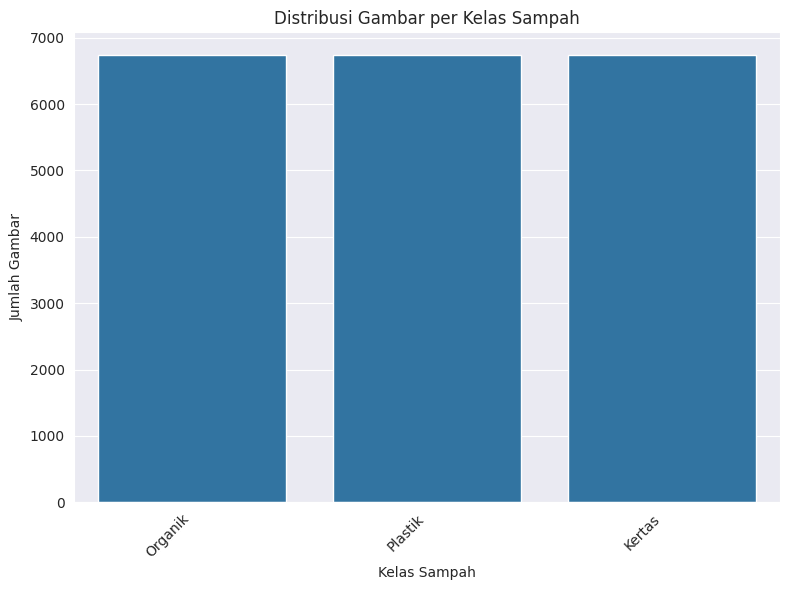

In [ ]:

path_data_utama = "/content/dataset"
# --- Selesai Penyesuaian Path ---

# Buat daftar untuk menyimpan data
file_name_list = []
labels_list = []
full_path_list = []

# Pastikan path utama ada
if not os.path.exists(path_data_utama):
    print(f"Error: Path '{path_data_utama}' tidak ditemukan. Pastikan sudah benar.")
else:
    print(f"Memproses data dari: {path_data_utama}")

    for root, subdirs, files in os.walk(path_data_utama):

        if root != path_data_utama and files:
            nama_kelas = os.path.basename(root) # Ini akan menjadi 'Organik', 'Kertas', dll.
            print(f"  Memproses kelas: {nama_kelas}")
            for name in files:
                # Pastikan hanya memproses file gambar yang umum (opsional, tapi baik untuk kebersihan data)
                if name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    full_path_list.append(os.path.join(root, name))
                    labels_list.append(nama_kelas)
                    file_name_list.append(name)
                else:
                    print(f"    Melewati file non-gambar: {name}")

    # Buat DataFrame dari daftar yang sudah dikumpulkan
    if full_path_list: # Hanya buat DataFrame jika ada data yang terkumpul
        df_distribusi = pd.DataFrame({
            "path": full_path_list,
            'file_name': file_name_list,
            "labels": labels_list
        })

        print("\nContoh beberapa data dari DataFrame:")
        print(df_distribusi.head())

        print(f"\nTotal gambar yang diproses: {len(df_distribusi)}")
        print("Distribusi kelas:")
        print(df_distribusi['labels'].value_counts())

        # Plot distribusi gambar di setiap kelas
        plt.figure(figsize=(8, 6)) # Ukuran plot bisa disesuaikan
        sns.set_style("darkgrid")
        plot = sns.countplot(x='labels', data=df_distribusi, order=df_distribusi['labels'].value_counts().index)
        plot.set_title('Distribusi Gambar per Kelas Sampah')
        plot.set_xlabel('Kelas Sampah')
        plot.set_ylabel('Jumlah Gambar')
        plt.xticks(rotation=45, ha='right') # Rotasi label sumbu x agar mudah dibaca jika nama kelas panjang
        plt.tight_layout() # Agar tidak ada yang terpotong
        plt.show()
    else:
        print("Tidak ada file gambar yang ditemukan untuk membuat DataFrame dan plot.")

#Data Splitting (Train, Valid, Test)

In [ ]:
# --- Pengaturan Path dan Rasio ---
path_sumber_dataset = "/content/dataset"
path_output_utama = "/content/split_dataset" # Folder tujuan untuk dataset yang sudah dibagi

In [ ]:
# Rasio pembagian
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

if not np.isclose(train_ratio + validation_ratio + test_ratio, 1.0):
    print("Error: Total rasio pembagian harus 1.0.")
    exit()

# --- Membuat Direktori Tujuan ---
dir_train = os.path.join(path_output_utama, 'train')
dir_validation = os.path.join(path_output_utama, 'validation')
dir_test = os.path.join(path_output_utama, 'test')

# Hapus direktori output utama jika sudah ada untuk memulai dari bersih (opsional)
if os.path.exists(path_output_utama):
    print(f"Menghapus direktori output yang sudah ada: {path_output_utama}")
    shutil.rmtree(path_output_utama)

os.makedirs(dir_train, exist_ok=True)
os.makedirs(dir_validation, exist_ok=True)
os.makedirs(dir_test, exist_ok=True)

print(f"Direktori tujuan dibuat di: {path_output_utama}")

Direktori tujuan dibuat di: /content/split_dataset


In [ ]:
# --- Proses Pembagian per Kelas ---
if not os.path.exists(path_sumber_dataset):
    print(f"Error: Path sumber dataset '{path_sumber_dataset}' tidak ditemukan.")
    exit()

for nama_kelas in os.listdir(path_sumber_dataset):
    path_kelas_sumber = os.path.join(path_sumber_dataset, nama_kelas)

    if os.path.isdir(path_kelas_sumber):
        print(f"\nMemproses kelas: {nama_kelas}")

        # Buat subfolder kelas di direktori train, validation, dan test
        os.makedirs(os.path.join(dir_train, nama_kelas), exist_ok=True)
        os.makedirs(os.path.join(dir_validation, nama_kelas), exist_ok=True)
        os.makedirs(os.path.join(dir_test, nama_kelas), exist_ok=True)

        # Dapatkan semua file gambar dari kelas ini
        semua_file_gambar = [f for f in os.listdir(path_kelas_sumber)
                             if os.path.isfile(os.path.join(path_kelas_sumber, f)) and
                             f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not semua_file_gambar:
            print(f"  Tidak ada file gambar ditemukan di kelas {nama_kelas}. Dilewati.")
            continue

        # Acak urutan file
        random.shuffle(semua_file_gambar)

        # Hitung jumlah file untuk setiap set
        jumlah_total_file = len(semua_file_gambar)
        jumlah_train = int(jumlah_total_file * train_ratio)
        jumlah_validation = int(jumlah_total_file * validation_ratio)
        # Jumlah test adalah sisanya untuk memastikan semua file terdistribusi
        jumlah_test = jumlah_total_file - jumlah_train - jumlah_validation

        print(f"  Total gambar: {jumlah_total_file}")
        print(f"  Jumlah train: {jumlah_train}")
        print(f"  Jumlah validation: {jumlah_validation}")
        print(f"  Jumlah test: {jumlah_test}")

        # Bagi daftar file
        files_train = semua_file_gambar[:jumlah_train]
        files_validation = semua_file_gambar[jumlah_train : jumlah_train + jumlah_validation]
        files_test = semua_file_gambar[jumlah_train + jumlah_validation :]

        # Fungsi untuk menyalin file
        def salin_file(daftar_file, folder_tujuan_kelas):
            for nama_file in daftar_file:
                path_asal = os.path.join(path_kelas_sumber, nama_file)
                path_tujuan = os.path.join(folder_tujuan_kelas, nama_file)
                shutil.copy2(path_asal, path_tujuan) # copy2 mempertahankan metadata

        # Salin file ke direktori masing-masing
        salin_file(files_train, os.path.join(dir_train, nama_kelas))
        salin_file(files_validation, os.path.join(dir_validation, nama_kelas))
        salin_file(files_test, os.path.join(dir_test, nama_kelas))

        print(f"  File untuk kelas {nama_kelas} telah berhasil dibagi.")

print("\n--- Pembagian Dataset Selesai ---")
print(f"Dataset yang sudah dibagi tersedia di: {path_output_utama}")
print("Struktur folder:")
print(f"{path_output_utama}/")
print(f"├── train/")
print(f"│   ├── Kelas1/")
print(f"│   ├── Kelas2/")
print(f"│   └── ...")
print(f"├── validation/")
print(f"│   ├── Kelas1/")
print(f"│   └── ...")
print(f"└── test/")
print(f"    ├── Kelas1/")
print(f"    └── ...")


Memproses kelas: Plastik
  Total gambar: 6742
  Jumlah train: 5393
  Jumlah validation: 674
  Jumlah test: 675
  File untuk kelas Plastik telah berhasil dibagi.

Memproses kelas: Organik
  Total gambar: 6742
  Jumlah train: 5393
  Jumlah validation: 674
  Jumlah test: 675
  File untuk kelas Organik telah berhasil dibagi.

Memproses kelas: Kertas
  Total gambar: 6742
  Jumlah train: 5393
  Jumlah validation: 674
  Jumlah test: 675
  File untuk kelas Kertas telah berhasil dibagi.

--- Pembagian Dataset Selesai ---
Dataset yang sudah dibagi tersedia di: /content/split_dataset
Struktur folder:
/content/split_dataset/
├── train/
│   ├── Kelas1/
│   ├── Kelas2/
│   └── ...
├── validation/
│   ├── Kelas1/
│   └── ...
└── test/
    ├── Kelas1/
    └── ...


# Image Generator

In [ ]:
import os

# Definisikan direktori
BASE_DIR = "split_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "validation")
TEST_DIR = os.path.join(BASE_DIR, "test")

# Path untuk setiap kelas di setiap set
train_kertas = os.path.join(TRAIN_DIR, 'Kertas')
train_organik = os.path.join(TRAIN_DIR, 'Organik')
train_plastik = os.path.join(TRAIN_DIR, 'Plastik')

val_kertas = os.path.join(VAL_DIR, 'Kertas')
val_organik = os.path.join(VAL_DIR, 'Organik')
val_plastik = os.path.join(VAL_DIR, 'Plastik')

test_kertas = os.path.join(TEST_DIR, 'Kertas')
test_organik = os.path.join(TEST_DIR, 'Organik')
test_plastik = os.path.join(TEST_DIR, 'Plastik')

# Hitung dan tampilkan jumlah gambar
print("=== Training Set ===")
print("Total Kertas images in training set:", len(os.listdir(train_kertas)))
print("Total Organik images in training set:", len(os.listdir(train_organik)))
print("Total Plastik images in training set:", len(os.listdir(train_plastik)))

print("\n=== Validation Set ===")
print("Total Kertas images in validation set:", len(os.listdir(val_kertas)))
print("Total Organik images in validation set:", len(os.listdir(val_organik)))
print("Total Plastik images in validation set:", len(os.listdir(val_plastik)))

print("\n=== Test Set ===")
print("Total Kertas images in test set:", len(os.listdir(test_kertas)))
print("Total Organik images in test set:", len(os.listdir(test_organik)))
print("Total Plastik images in test set:", len(os.listdir(test_plastik)))

=== Training Set ===
Total Kertas images in training set: 5393
Total Organik images in training set: 5393
Total Plastik images in training set: 5393

=== Validation Set ===
Total Kertas images in validation set: 674
Total Organik images in validation set: 674
Total Plastik images in validation set: 674

=== Test Set ===
Total Kertas images in test set: 675
Total Organik images in test set: 675
Total Plastik images in test set: 675


In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(250,250),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              shuffle=True)

validation_generator = val_datagen.flow_from_directory(VAL_DIR,
                                                   batch_size=32,
                                                   target_size=(250,250),
                                                   color_mode="rgb",
                                                   class_mode='categorical',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(250,250),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 16179 images belonging to 3 classes.
Found 2022 images belonging to 3 classes.
Found 2025 images belonging to 3 classes.


# Modelling

In [ ]:
tf.keras.backend.clear_session()

# --- 1. Pengaturan Input Shape dan Pemuatan Model Dasar VGG16 ---
IMG_WIDTH = 250
IMG_HEIGHT = 250
IMG_CHANNELS = 3

print(f"Menggunakan input shape: ({IMG_WIDTH}, {IMG_HEIGHT}, {IMG_CHANNELS})")

print("Memuat model dasar VGG16 dengan bobot ImageNet...")
try:
    base_model_vgg16 = VGG16(weights='imagenet',
                             include_top=False,
                             input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    base_model_vgg16.trainable = False
    print("Model dasar VGG16 berhasil dimuat dan bobotnya dibekukan.")
except Exception as e:
    print(f"Error saat memuat base_model_vgg16: {e}")
    raise

Menggunakan input shape: (250, 250, 3)
Memuat model dasar VGG16 dengan bobot ImageNet...
Model dasar VGG16 berhasil dimuat dan bobotnya dibekukan.


In [ ]:
# --- 2. Membuat Model Sequential (kita beri nama model_final) ---
print("\nMembuat arsitektur model transfer learning...")
try:
    model_final = Sequential([
        base_model_vgg16,
        Conv2D(128, (3, 3), activation='relu', padding='same', name='custom_conv1'),
        MaxPooling2D(pool_size=(2, 2), name='custom_maxpool1'),
        Flatten(name='flatten_custom'),
        Dense(128, activation='relu', name='custom_dense1'),
        BatchNormalization(name='custom_dense_bn1'),
        Dropout(0.5, name='custom_dropout1'),
        Dense(64, activation='relu', name='custom_dense2'),
        BatchNormalization(name='custom_dense_bn2'),
        Dropout(0.3, name='custom_dropout2'),
        Dense(3, activation='softmax', name='output_softmax')
    ], name="EcoWaste_VGG16_CustomConv_Model")
    print("Arsitektur model berhasil dibuat.")

    # --- 3. Kompilasi Model ---
    print("\nMengkompilasi model...")
    model_final.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print("Model berhasil dikompilasi.")

    print("\nRingkasan Model:")
    model_final.summary()

except NameError as ne:
    print(f"NameError saat membuat atau mengkompilasi model: {ne}")
    print("Ini seharusnya tidak terjadi jika 'base_model_vgg16' sudah terdefinisi dengan benar di atas.")
except Exception as e:
    print(f"Error lain saat membuat atau mengkompilasi model: {e}")
    raise


Membuat arsitektur model transfer learning...
Arsitektur model berhasil dibuat.

Mengkompilasi model...
Model berhasil dikompilasi.

Ringkasan Model:


Model: "EcoWaste_VGG16_CustomConv_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_conv1 (Conv2D)           │ (None, 7, 7, 128)      │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_maxpool1 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_custom (Flatten)        │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dense1 (Dense)           │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dense_bn1                │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dropout1 (Dropout)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dense2 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dense_bn2                │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dropout2 (Dropout)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Dense)          │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,461,443 (58.98 MB)

 Trainable params: 746,371 (2.85 MB)

 Non-trainable params: 14,715,072 (56.13 MB)

In [ ]:
# --- 4. Definisikan Callbacks (di sel yang sama atau sel berikutnya) ---
print("\nMendefinisikan callbacks...")
checkpoint = ModelCheckpoint(
    'best_ecowaste_model.keras', # Simpan dengan format .keras (direkomendasikan)
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7, # Jumlah epoch tanpa peningkatan sebelum berhenti
    restore_best_weights=True,
    verbose=1
)
print("Callbacks berhasil didefinisikan.")


Mendefinisikan callbacks...
Callbacks berhasil didefinisikan.


In [ ]:
# --- 5. Pelatihan Model ---
print("\nMemulai pelatihan model VGG16 dengan Custom MaxPooling...")
# Pastikan train_generator dan validation_generator sudah ada
if 'train_generator' not in globals() or 'validation_generator' not in globals():
    print("Error: `train_generator` atau `validation_generator` belum terdefinisi.")
    print("Pastikan Anda sudah menjalankan sel kode yang membuat generator data tersebut.")
else:
    history_vgg = model_final.fit(
        train_generator,
        epochs=25, # atau 30, sesuai kebutuhan
        validation_data=validation_generator,
        callbacks=[checkpoint, early_stopping] # Pastikan checkpoint dan early_stopping juga sudah terdefinisi
    )


Memulai pelatihan model VGG16 dengan Custom MaxPooling...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
 31/506 ━━━━━━━━━━━━━━━━━━━━ 2:08 271ms/step - accuracy: 0.5922 - loss: 1.1152

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.7971 - loss: 0.5455
Epoch 1: val_loss improved from inf to 0.43381, saving model to best_ecowaste_model.keras
506/506 ━━━━━━━━━━━━━━━━━━━━ 210s 370ms/step - accuracy: 0.7972 - loss: 0.5453 - val_accuracy: 0.8541 - val_loss: 0.4338
Epoch 2/25
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.8993 - loss: 0.2819
Epoch 2: val_loss improved from 0.43381 to 0.29826, saving model to best_ecowaste_model.keras
506/506 ━━━━━━━━━━━━━━━━━━━━ 150s 295ms/step - accuracy: 0.8993 - loss: 0.2819 - val_accuracy: 0.8971 - val_loss: 0.2983
Epoch 3/25
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9176 - loss: 0.2289
Epoch 3: val_loss improved from 0.29826 to 0.24603, saving model to best_ecowaste_model.keras
506/506 ━━━━━━━━━━━━━━━━━━━━ 146s 288ms/step - accuracy: 0.9176 - loss: 0.2290 - val_accuracy: 0.9144 - val_loss: 0.2460
Epoch 4/25
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9321 - loss: 0.1955
Epoch 4: val_loss 

# Evaluasi

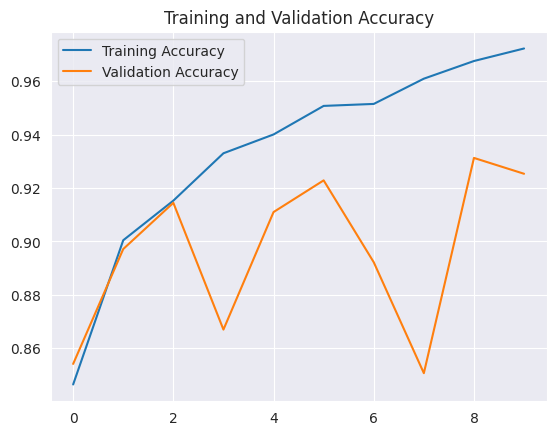

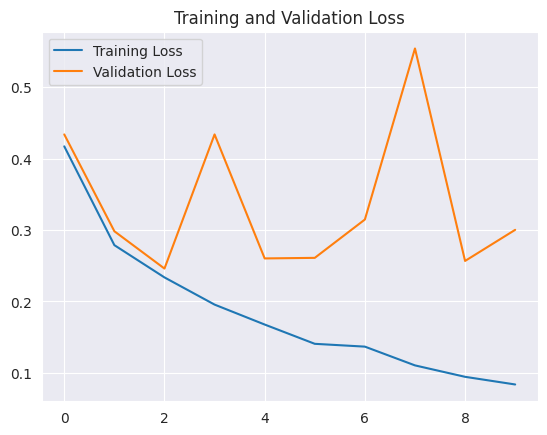

In [ ]:
plt.plot(history_vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(history_vgg.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Menggunakan model 'model_final' yang sudah ada di memori untuk evaluasi.
Validation generator siap.

Melakukan prediksi pada data validasi...
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 274ms/step
Prediksi selesai.

Nama Kelas (sesuai urutan indeks): ['Kertas', 'Organik', 'Plastik']

Confusion Matrix:
[[626  10  38]
 [ 37 603  34]
 [ 49   5 620]]


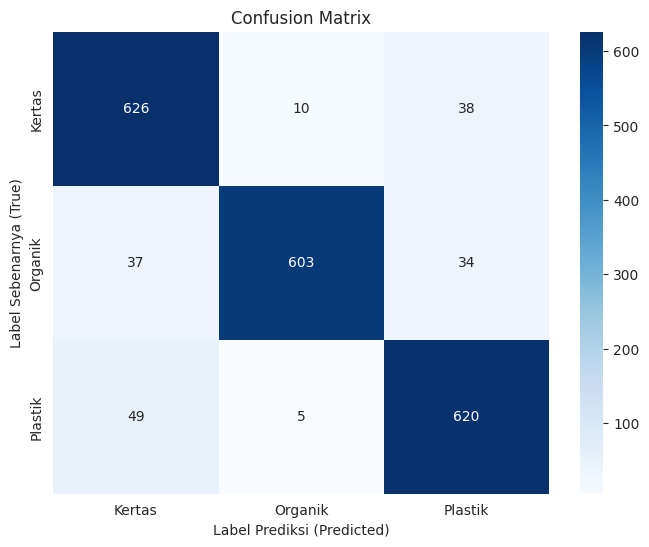


Classification Report:
              precision    recall  f1-score   support

      Kertas       0.88      0.93      0.90       674
     Organik       0.98      0.89      0.93       674
     Plastik       0.90      0.92      0.91       674

    accuracy                           0.91      2022
   macro avg       0.92      0.91      0.91      2022
weighted avg       0.92      0.91      0.91      2022



In [ ]:
if 'model_final' in globals(): # Cek apakah variabel model_final ada
    model_untuk_evaluasi = model_final
    print("Menggunakan model 'model_final' yang sudah ada di memori untuk evaluasi.")
else:
    # Jika model_final tidak ada, coba muat dari file sebagai fallback
    print("'model_final' tidak ditemukan di memori, mencoba memuat dari file...")
    path_model_terbaik = 'best_ecowaste_model.keras' # Sesuaikan jika nama file Anda berbeda
    try:
        model_untuk_evaluasi = tf.keras.models.load_model(path_model_terbaik)
        print(f"Model berhasil dimuat dari: {path_model_terbaik}")
    except Exception as e:
        print(f"Error saat memuat model dari file: {e}")
        print("Pastikan model sudah dilatih dan disimpan, atau variabel model sudah ada di memori.")
        raise # Hentikan jika model tidak bisa didapatkan

# --- 2. Persiapan Validation Generator (Pastikan sudah ada dari notebook Anda) ---
if 'validation_generator' not in globals():
    print("Error: 'validation_generator' tidak ditemukan.")
    raise NameError("validation_generator tidak terdefinisi")
validation_generator.reset()
print("Validation generator siap.")

# --- 3. Dapatkan Prediksi dari Model ---
print("\nMelakukan prediksi pada data validasi...")
steps_for_prediction = int(np.ceil(validation_generator.samples / validation_generator.batch_size))
Y_pred_probabilities = model_untuk_evaluasi.predict(validation_generator, steps=steps_for_prediction, verbose=1)
y_pred_indices = np.argmax(Y_pred_probabilities, axis=1)
print("Prediksi selesai.")

# --- 4. Dapatkan Label Sebenarnya (True Labels) ---
y_true_indices = validation_generator.classes
if len(y_pred_indices) != len(y_true_indices):
    y_true_indices = y_true_indices[:len(y_pred_indices)] # Penyesuaian jika perlu

# --- 5. Dapatkan Nama Kelas ---
class_names = list(validation_generator.class_indices.keys())
sorted_class_names = [k for k, v in sorted(validation_generator.class_indices.items(), key=lambda item: item[1])]
print("\nNama Kelas (sesuai urutan indeks):", sorted_class_names)

# --- 6. Hitung dan Tampilkan Confusion Matrix ---
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true_indices, y_pred_indices)
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted_class_names, yticklabels=sorted_class_names)
plt.title('Confusion Matrix')
plt.ylabel('Label Sebenarnya (True)')
plt.xlabel('Label Prediksi (Predicted)')
plt.show()

# --- 7. Tampilkan Classification Report ---
print("\nClassification Report:")
report = classification_report(y_true_indices, y_pred_indices, target_names=sorted_class_names, zero_division=0)
print(report)

In [ ]:
from google.colab import files

# Ganti dengan nama file model Anda yang sebenarnya jika berbeda
nama_file_model = 'best_ecowaste_model.keras' # atau 'best_model_vgg_plus_conv.h5', dll.

# Path lengkap ke file model di Colab (biasanya di /content/)
path_ke_model_di_colab = f'/content/{nama_file_model}'

# Periksa apakah file model ada sebelum mencoba mengunduh
import os
if os.path.exists(path_ke_model_di_colab):
    print(f"Mempersiapkan unduhan untuk: {path_ke_model_di_colab}...")
    files.download(path_ke_model_di_colab)
    print("Jika unduhan tidak dimulai otomatis, periksa pengaturan pop-up browser Anda.")
    print(f"Ukuran file model: {os.path.getsize(path_ke_model_di_colab) / (1024*1024):.2f} MB")
else:
    print(f"Error: File model '{path_ke_model_di_colab}' tidak ditemukan.")
    print("Pastikan ModelCheckpoint sudah berjalan dan menyimpan model dengan nama yang benar,")
    print("atau model sudah dilatih dan disimpan secara manual dengan nama tersebut.")

Mempersiapkan unduhan untuk: /content/best_ecowaste_model.keras...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Jika unduhan tidak dimulai otomatis, periksa pengaturan pop-up browser Anda.
Ukuran file model: 64.79 MB
